Init Plugin
Init Graph Optimizer
Init Kernel
GPUs [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Track generation: 974..1228 -> 254-tiles track


/usr/local/Caskroom/miniforge/base/envs/ann/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ann/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2022-07-11 13:22:36.554418: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-11 13:22:36.554554: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

episode: 1/10000, score: -88.14229249011761, average: -88.14 
Track generation: 1240..1554 -> 314-tiles track
episode: 2/10000, score: -90.41533546325773, average: -89.28 
Track generation: 1264..1584 -> 320-tiles track
episode: 3/10000, score: -93.73040752350991, average: -90.76 
Track generation: 1172..1469 -> 297-tiles track
episode: 4/10000, score: -93.24324324324222, average: -91.38 
Track generation: 1224..1534 -> 310-tiles track
episode: 5/10000, score: -93.52750809061384, average: -91.81 
Track generation: 1111..1393 -> 282-tiles track


2022-07-11 13:23:09.280937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-11 13:23:10.215811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-11 13:23:10.225509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-11 13:23:10.235918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-11 13:23:28.966729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-11 13:23:28.979075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-11 13:23:28.989866: I tensorflow/core/grappler/optimizers/cust

episode: 6/10000, score: -92.88256227757907, average: -91.99 
Track generation: 1164..1459 -> 295-tiles track
episode: 7/10000, score: -89.79591836734592, average: -91.68 
Track generation: 1078..1352 -> 274-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1137..1425 -> 288-tiles track
episode: 8/10000, score: -93.0313588850164, average: -91.85 
Track generation: 1204..1509 -> 305-tiles track
episode: 9/10000, score: -93.42105263157791, average: -92.02 
Track generation: 1159..1458 -> 299-tiles track
episode: 10/10000, score: -93.28859060402581, average: -92.15 
Track generation: 1131..1418 -> 287-tiles track
episode: 11/10000, score: -93.00699300699199, average: -92.23 
Track generation: 1304..1634 -> 330-tiles track
episode: 12/10000, score: -90.88145896656428, average: -92.11 
Track generation: 1216..1522 -> 306-tiles track
episode: 13/10000, score: -90.16393442622847, average: -91.96 
Track generation: 1090..1367 -> 277-t

KeyboardInterrupt: 

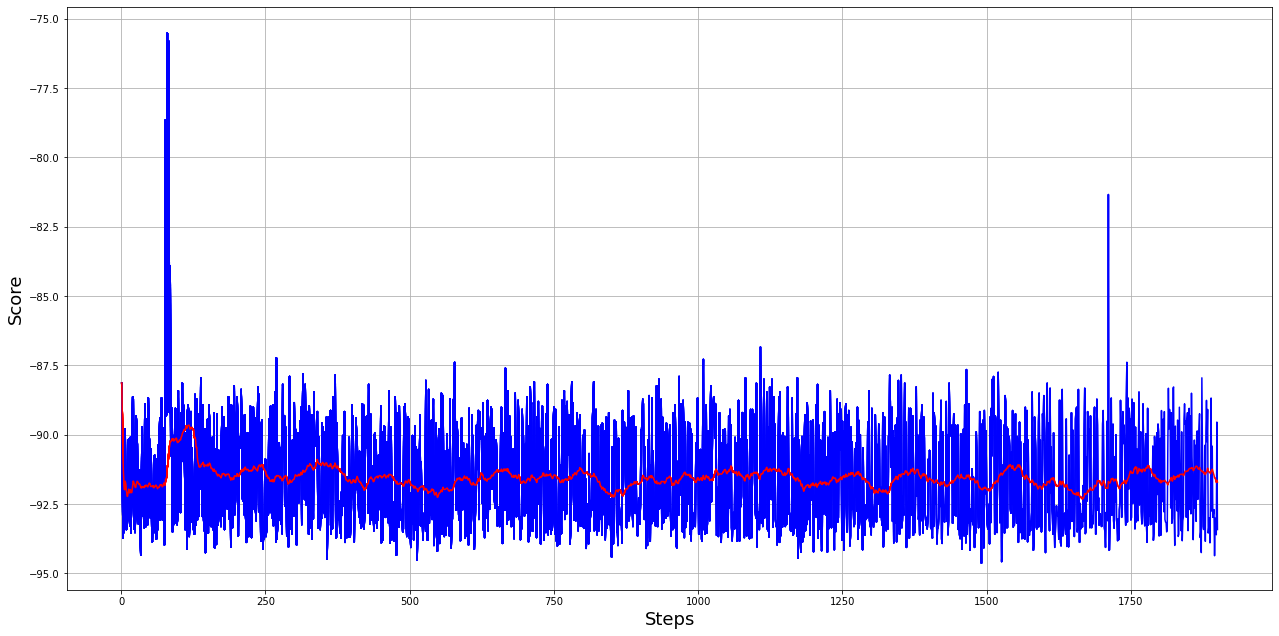

In [1]:
#================================================================
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # -1:cpu, 0:first gpu
import random
import datetime
import gym
import pylab
import numpy as np
import tensorflow as tf

# tensorboard init
from tensorboardX import SummaryWriter
%load_ext tensorboard
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tf.config.experimental_run_functions_eagerly(True) # used for debuging and development
tf.compat.v1.disable_eager_execution() # usually using this for fastest performance
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad, Adadelta
from tensorflow.keras import backend as K
import copy
from tqdm import tqdm_notebook


from threading import Thread, Lock
from multiprocessing import Process, Pipe


gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    print(f'GPUs {gpus}')
    try: tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError: pass

class Environment(Process):
    def __init__(self, env_idx, child_conn, env_name, state_size, action_size, visualize=False):
        super(Environment, self).__init__()
        self.env = gym.make(env_name)
        self.is_render = visualize
        self.env_idx = env_idx
        self.child_conn = child_conn
        self.state_size = state_size
        self.action_size = action_size

    def run(self):
        super(Environment, self).run()
        state = self.env.reset()
        #state = np.reshape(state, [1, self.state_size])
        self.child_conn.send(state)
        while True:
            action = self.child_conn.recv()
            #if self.is_render and self.env_idx == 0:
                #self.env.render()

            state, reward, done, info = self.env.step(action)
            state = np.reshape(state, [1, self.state_size])

            if done:
                state = self.env.reset()
                state = np.reshape(state, [1, self.state_size])

            self.child_conn.send([state, reward, done, info])


class Actor_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)
        self.action_space = action_space
        
        X = Conv2D(filters=6, kernel_size=(7,7), strides=3, activation='relu')(X_input)
        X = MaxPooling2D()(X)
        X = Conv2D(filters=12, kernel_size=(4,4), activation='relu')(X)
        X = MaxPooling2D()(X)
        X = Flatten()(X)
        X = Dense(216, activation='relu')(X)
        output = Dense(self.action_space, activation="tanh")(X)

        self.Actor = Model(inputs = X_input, outputs = output)
        self.Actor.compile(loss=self.ppo_loss_continuous, optimizer=optimizer(lr=lr))
        #print(self.Actor.summary())

    def ppo_loss_continuous(self, y_true, y_pred):
        advantages, actions, logp_old_ph, = y_true[:, :1], y_true[:, 1:1+self.action_space], y_true[:, 1+self.action_space]
        LOSS_CLIPPING = 0.2
        logp = self.gaussian_likelihood(actions, y_pred)

        ratio = K.exp(logp - logp_old_ph)

        p1 = ratio * advantages
        p2 = tf.where(advantages > 0, (1.0 + LOSS_CLIPPING)*advantages, (1.0 - LOSS_CLIPPING)*advantages) # minimum advantage

        actor_loss = -K.mean(K.minimum(p1, p2))

        return actor_loss

    def gaussian_likelihood(self, actions, pred): # for keras custom loss
        log_std = -0.5 * np.ones(self.action_space, dtype=np.float32)
        pre_sum = -0.5 * (((actions-pred)/(K.exp(log_std)+1e-8))**2 + 2*log_std + K.log(2*np.pi))
        return K.sum(pre_sum, axis=1)

    def predict(self, state):
        return self.Actor.predict(state)


class Critic_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)
        old_values = Input(shape=(1,))

        X = Conv2D(filters=6, kernel_size=(7,7), strides=3, activation='relu')(X_input)
        X = MaxPooling2D()(X)
        X = Conv2D(filters=12, kernel_size=(4,4), activation='relu')(X)
        X = MaxPooling2D()(X)
        X = Flatten()(X)
        X = Dense(216, activation='relu')(X)
        value = Dense(1, activation=None)(X)

        self.Critic = Model(inputs=[X_input, old_values], outputs = value)
        self.Critic.compile(loss=[self.critic_PPO2_loss(old_values)], optimizer=optimizer(lr=lr))

    def critic_PPO2_loss(self, values):
        def loss(y_true, y_pred):
            LOSS_CLIPPING = 0.2
            clipped_value_loss = values + K.clip(y_pred - values, -LOSS_CLIPPING, LOSS_CLIPPING)
            v_loss1 = (y_true - clipped_value_loss) ** 2
            v_loss2 = (y_true - y_pred) ** 2
            
            value_loss = 0.5 * K.mean(K.maximum(v_loss1, v_loss2))
            #value_loss = K.mean((y_true - y_pred) ** 2) # standard PPO loss
            return value_loss
        return loss

    def predict(self, state):
        return self.Critic.predict([state, np.zeros((state.shape[0], 1))])
        # return self.Critic.predict(state)
    

class PPOAgent:
    # PPO Main Optimization Algorithm
    def __init__(self, env_name, model_name=""):
        # Initialization
        # Environment and PPO parameters
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.action_size = self.env.action_space.shape[0]
        self.state_size = self.env.observation_space.shape
        self.EPISODES = 10000 # total episodes to train through all environments
        self.episode = 0 # used to track the episodes total count of episodes played through all thread environments
        self.max_average = 0 # when average score is above 0 model will be saved
        self.lr = 0.00025
        self.epochs = 10 # training epochs
        self.shuffle = True
        self.Training_batch = 5000
        #self.optimizer = RMSprop
        self.optimizer = Adam

        self.replay_count = 0
        self.writer = SummaryWriter(comment="_"+self.env_name+"_"+self.optimizer.__name__+"_"+str(self.lr))
        
        # Instantiate plot memory
        self.scores_, self.episodes_, self.average_ = [], [], [] # used in matplotlib plots

        # Create Actor-Critic network models
        self.Actor = Actor_Model(input_shape=self.state_size, action_space = self.action_size, lr=self.lr, optimizer = self.optimizer)
        self.Critic = Critic_Model(input_shape=self.state_size, action_space = self.action_size, lr=self.lr, optimizer = self.optimizer)
        
        self.Actor_name = f"{self.env_name}_PPO_Actor.h5"
        self.Critic_name = f"{self.env_name}_PPO_Critic.h5"
        #self.load() # uncomment to continue training from old weights

        # do not change bellow
        self.log_std = -0.5 * np.ones(self.action_size, dtype=np.float32)
        self.std = np.exp(self.log_std)
        self.std_new = 0.2


    def act(self, state):
        # Use the network to predict the next actions mu and sigma 
        pred = self.Actor.predict(np.expand_dims(state, axis=0))
        pred_flat = pred.flatten()

        # split the actions
        steering = pred_flat[0]
        gas = pred_flat[1]
        breaks = pred_flat[2]

        # print(f'PredFalt: {pred_flat}   Steering: {steering} Gas: {gas} Breaks: {breaks}')


        gas_normalized = self.normalizeNP(gas)
        breaks_normalized = self.normalizeNP(breaks)
    

        sampled_gas = np.random.normal(gas_normalized, self.std_new)

        sampled_breaks = np.random.normal(breaks_normalized, self.std_new)

        sampled_steering = np.random.normal(steering, self.std_new)


        # clipping the values on bounds 
        clipped_gas = np.clip(sampled_gas, 0,1)
        clipped_breaks =  np.clip(sampled_breaks, 0,1)
        clipped_steering = np.clip(sampled_steering,-1,1)

        # # concat the values back together to create one action tensor to sample from
        action = np.array([clipped_steering,clipped_gas, clipped_breaks])

        action = np.reshape(action, pred.shape)

        logp_t = self.gaussian_likelihood(action, pred, self.log_std)

        return action, logp_t


    def normalize(self, tensor):
        
        #  set upper and lower bounds for the tanh produced outcome
        min_bound = tf.constant([-1], dtype=tf.float32)
        max_bound = tf.constant([1], dtype=tf.float32)
        
        #  create an epsilon to avoid division by 0
        eps = tf.constant([1e-12], dtype=tf.float32)

        # normalize by the following formular https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/
        tensor = tf.divide((tensor - min_bound), tf.maximum((max_bound - min_bound),eps))

        return tensor

    def normalizeNP(self, x):
        return ((x-(-1)) / np.maximum((1-(-1)), 1e-12))

    def gaussian_likelihood(self, action, pred, log_std):
        # https://github.com/hill-a/stable-baselines/blob/master/stable_baselines/sac/policies.py
        pre_sum = -0.5 * (((action-pred)/(np.exp(log_std)+1e-8))**2 + 2*log_std + np.log(2*np.pi)) 
        return np.sum(pre_sum, axis=1)

    def discount_rewards(self, reward):#gaes is better
        # Compute the gamma-discounted rewards over an episode
        # We apply the discount and normalize it to avoid big variability of rewards
        gamma = 0.99    # discount rate
        running_add = 0
        discounted_r = np.zeros_like(reward)
        for i in reversed(range(0,len(reward))):
            running_add = running_add * gamma + reward[i]
            discounted_r[i] = running_add

        discounted_r -= np.mean(discounted_r) # normalizing the result
        discounted_r /= (np.std(discounted_r) + 1e-8) # divide by standard deviation
        return discounted_r

    def get_gaes(self, rewards, dones, values, next_values, gamma = 0.99, lamda = 0.90, normalize=True):
        deltas = [r + gamma * (1 - d) * nv - v for r, d, nv, v in zip(rewards, dones, next_values, values)]
        deltas = np.stack(deltas)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(deltas) - 1)):
            gaes[t] = gaes[t] + (1 - dones[t]) * gamma * lamda * gaes[t + 1]

        target = gaes + values
        if normalize:
            gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)
        return np.vstack(gaes), np.vstack(target)

    def replay(self, states, actions, rewards, dones, next_states, logp_ts):
        # reshape memory to appropriate shape for training
        states = np.vstack(states)
        next_states = np.vstack(next_states)
        actions = np.vstack(actions)
        logp_ts = np.vstack(logp_ts)

        # Get Critic network predictions 
        # print(states.shape)
        # print(np.expand_dims(states, axis=0).shape)
        values = self.Critic.predict(states)

        next_values = self.Critic.predict(next_states)

        # Compute discounted rewards and advantages
        #discounted_r = self.discount_rewards(rewards)
        #advantages = np.vstack(discounted_r - values)
        advantages, target = self.get_gaes(rewards, dones, np.squeeze(values), np.squeeze(next_values))
        '''
        pylab.plot(adv,'.')
        pylab.plot(target,'-')
        ax=pylab.gca()
        ax.grid(True)
        pylab.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.06)
        pylab.show()
        if str(episode)[-2:] == "00": pylab.savefig(self.env_name+"_"+self.episode+".png")
        '''
        # stack everything to numpy array
        # pack all advantages, predictions and actions to y_true and when they are received
        # in custom loss function we unpack it
        y_true = np.hstack([advantages, actions, logp_ts])
        
        # training Actor and Critic networks
        a_loss = self.Actor.Actor.fit(states, y_true, epochs=self.epochs, verbose=0, shuffle=self.shuffle)
        c_loss = self.Critic.Critic.fit([states, values], target, epochs=self.epochs, verbose=0, shuffle=self.shuffle)

        # calculate loss parameters (should be done in loss, but couldn't find working way how to do that with disabled eager execution)
        pred = self.Actor.predict(states)
        log_std = -0.5 * np.ones(self.action_size, dtype=np.float32)
        logp = self.gaussian_likelihood(actions, pred, log_std)
        approx_kl = np.mean(logp_ts - logp)
        approx_ent = np.mean(-logp)

        self.writer.add_scalar('Data/actor_loss_per_replay', np.sum(a_loss.history['loss']), self.replay_count)
        self.writer.add_scalar('Data/critic_loss_per_replay', np.sum(c_loss.history['loss']), self.replay_count)
        self.writer.add_scalar('Data/approx_kl_per_replay', approx_kl, self.replay_count)
        self.writer.add_scalar('Data/approx_ent_per_replay', approx_ent, self.replay_count)
        self.replay_count += 1
 
    def load(self):
        self.Actor.Actor.load_weights(self.Actor_name)
        self.Critic.Critic.load_weights(self.Critic_name)

    def save(self):
        self.Actor.Actor.save_weights(self.Actor_name)
        self.Critic.Critic.save_weights(self.Critic_name)

    pylab.figure(figsize=(18, 9))
    pylab.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.06)
    def PlotModel(self, score, episode, save=True):
        self.scores_.append(score)
        self.episodes_.append(episode)
        self.average_.append(sum(self.scores_[-50:]) / len(self.scores_[-50:]))
        if str(episode)[-2:] == "00":# much faster than episode % 100
            pylab.plot(self.episodes_, self.scores_, 'b')
            pylab.plot(self.episodes_, self.average_, 'r')
            pylab.ylabel('Score', fontsize=18)
            pylab.xlabel('Steps', fontsize=18)
            try:
                pylab.grid(True)
                pylab.savefig(self.env_name+".png")
            except OSError:
                pass
        # saving best models
        if self.average_[-1] >= self.max_average and save:
            self.max_average = self.average_[-1]
            self.save()
            SAVING = "SAVING"
            # decreaate learning rate every saved model
            #self.lr *= 0.99
            #K.set_value(self.Actor.Actor.optimizer.learning_rate, self.lr)
            #K.set_value(self.Critic.Critic.optimizer.learning_rate, self.lr)
        else:
            SAVING = ""

        return self.average_[-1], SAVING
    
    def run_batch(self):
        state = self.env.reset()
        #print(state.shape)
        done, score, SAVING = False, 0, ''
        while True:
            # Instantiate or reset games memory
            states, next_states, actions, rewards, dones, logp_ts = [], [], [], [], [], []
            for t in range(self.Training_batch):
                # self.env.render()
                if self.episode % 1000 == 0:
                    self.env.render()
                # Actor picks an action
                action, logp_t = self.act(state)
                # Retrieve new state, reward, and whether the state is terminal
                next_state, reward, done, _ = self.env.step(action[0])
                # Memorize (state, next_states, action, reward, done, logp_ts) for training
                states.append(np.expand_dims(state, axis=0))
                # next_states.append(np.reshape(next_state, [1, self.state_size[0]]))
                next_states.append(np.expand_dims(next_state, axis=0))
                actions.append(action)
                rewards.append(reward)
                dones.append(done)
                logp_ts.append(logp_t[0])

                score += reward
                if done:
                    self.episode += 1
                    average, SAVING = self.PlotModel(score, self.episode)
                    print("episode: {}/{}, score: {}, average: {:.2f} {}".format(self.episode, self.EPISODES, score, average, SAVING))
                    self.writer.add_scalar(f'Workers:{1}/score_per_episode', score, self.episode)
                    self.writer.add_scalar(f'Workers:{1}/learning_rate', self.lr, self.episode)
                    self.writer.add_scalar(f'Workers:{1}/average_score',  average, self.episode)
                    
                    state, done, score, SAVING = self.env.reset(), False, 0, ''
                    #state = np.reshape(state, [1, self.state_size[0]])

            self.replay(states, actions, rewards, dones, next_states, logp_ts)
            if self.episode >= self.EPISODES:
                break

        self.env.close()


    def run_multiprocesses(self, num_worker = 4):
        works, parent_conns, child_conns = [], [], []
        for idx in range(num_worker):
            parent_conn, child_conn = Pipe()
            work = Environment(idx, child_conn, self.env_name, self.state_size[0], self.action_size, True)
            work.start()
            works.append(work)
            parent_conns.append(parent_conn)
            child_conns.append(child_conn)

        states =        [[] for _ in range(num_worker)]
        next_states =   [[] for _ in range(num_worker)]
        actions =       [[] for _ in range(num_worker)]
        rewards =       [[] for _ in range(num_worker)]
        dones =         [[] for _ in range(num_worker)]
        logp_ts =       [[] for _ in range(num_worker)]
        score =         [0 for _ in range(num_worker)]

        state = [0 for _ in range(num_worker)]
        for worker_id, parent_conn in enumerate(parent_conns):
            state[worker_id] = parent_conn.recv()

        while self.episode < self.EPISODES:
            # get batch of action's and log_pi's
            action, logp_pi = self.act(np.reshape(state, [num_worker, self.state_size[0]]))
            
            for worker_id, parent_conn in enumerate(parent_conns):
                parent_conn.send(action[worker_id])
                actions[worker_id].append(action[worker_id])
                logp_ts[worker_id].append(logp_pi[worker_id])

            for worker_id, parent_conn in enumerate(parent_conns):
                next_state, reward, done, _ = parent_conn.recv()

                states[worker_id].append(state[worker_id])
                next_states[worker_id].append(next_state)
                rewards[worker_id].append(reward)
                dones[worker_id].append(done)
                state[worker_id] = next_state
                score[worker_id] += reward

                if done:
                    average, SAVING = self.PlotModel(score[worker_id], self.episode)
                    print("episode: {}/{}, worker: {}, score: {}, average: {:.2f} {}".format(self.episode, self.EPISODES, worker_id, score[worker_id], average, SAVING))
                    self.writer.add_scalar(f'Workers:{num_worker}/score_per_episode', score[worker_id], self.episode)
                    self.writer.add_scalar(f'Workers:{num_worker}/learning_rate', self.lr, self.episode)
                    self.writer.add_scalar(f'Workers:{num_worker}/average_score',  average, self.episode)
                    score[worker_id] = 0
                    if(self.episode < self.EPISODES):
                        self.episode += 1
                        
                        
            for worker_id in range(num_worker):
                if len(states[worker_id]) >= self.Training_batch:
                    self.replay(states[worker_id], actions[worker_id], rewards[worker_id], dones[worker_id], next_states[worker_id], logp_ts[worker_id])

                    states[worker_id] = []
                    next_states[worker_id] = []
                    actions[worker_id] = []
                    rewards[worker_id] = []
                    dones[worker_id] = []
                    logp_ts[worker_id] = []

        # terminating processes after a while loop
        works.append(work)
        for work in works:
            work.terminate()
            print('TERMINATED:', work)
            work.join()

    def test(self, test_episodes = 100):#evaluate
        self.load()
        for e in range(101):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size[0]])
            done = False
            score = 0
            while not done:
                self.env.render()
                action = self.Actor.predict(state)[0]
                state, reward, done, _ = self.env.step(action)
                state = np.reshape(state, [1, self.state_size[0]])
                score += reward
                if done:
                    average, SAVING = self.PlotModel(score, e, save=False)
                    print("episode: {}/{}, score: {}, average{}".format(e, test_episodes, score, average))
                    break
        self.env.close()
            

if __name__ == "__main__":
    
    env_name = 'CarRacing-v0'
    agent = PPOAgent(env_name)
    agent.run_batch() # train as PPO
 
    #agent.run_multiprocesses(num_worker = 16)  # train PPO multiprocessed (fastest)
    #agent.test()